# Strategy Learner
ML for trading Udacity Course exercise

More info:
https://quantsoftware.gatech.edu/Strategy_learner

A transcription of the Udacity Course lectures can be find on https://docs.google.com/document/d/1ELqlnuTSdc9-MDHOkV0uvSY4RmI1eslyQlU9DgOY_jc/edit?usp=sharing

Kairoart 2018
"""


## Overview

In this project you will design a learning trading agent. You must draw on the learners you have created so far in the course. Your choices are:

1. Regression or classification-based learner: Create a strategy using your Random Forest learner. Suggestions if you follow this approach: Classification_Trader_Hints. Important note, if you choose this method, you must set the leaf_size for your learner to 5 or greater. This is to avoid degenerate overfitting in-sample.
2. Reinforcement Learner-based approach: Create a Q-learning-based strategy using your Q-Learner. Read the Classification_Trader_Hints first, because many of the ideas there are relevant for the Q trader, then see Q_Trader_Hints
3. Optimization-based learner: Create a scan-based strategy using an optimizer. Read the Classification_Trader_Hints first, because many of the ideas there are relevant for the Opto trader, then see Opto_Trader_Hints

Regardless of your choice above, your learner should work in the following way:

* In the training phase (e.g., addEvidence()) your learner will be provided with a stock symbol and a time period. It should use this data to learn a strategy. For instance, for a regression-based learner it will use this data to make predictions about future price changes.
* In the testing phase (e.g., testPolicy()) your learner will be provided a symbol and a date range. All learning should be turned OFF during this phase.


If the date range is the same as used for the training, it is an in-sample test. Otherwise it is an out-of-sample test. Your learner should return a trades dataframe like it did in the last project. Here are some important requirements: Your testPolicy() method should be much faster than your addEvidence() method. The timeout requirements (see rubric) will be set accordingly. Multiple calls to your testPolicy() method should return exactly the same result. 

## Tasks

* Devise numerical/technical indicators to evaluate the state of a stock on each day.
* Build a strategy learner based on one of the learners described above that uses the indicators.
* Test/debug the strategy learner on specific symbol/time period problems.
* Write a report describing your learning strategy.

## Data Details, Dates and Rules

* For your report, trade only the symbol JPM. This will enable us to more easily compare results. We will test your learner with other symbols as well.
* You may use data from other symbols (such as SPY) to inform your strategy.
* The in sample/development period is January 1, 2008 to December 31 2009.
* The out of sample/testing period is January 1, 2010 to December 31 2011.
* Starting cash is 100,000.
* Allowable positions are: 1000 shares long, 1000 shares short, 0 shares.
* Benchmark: The performance of a portfolio starting with 100,000 cash, investing in 1000 shares of the symbol in use and holding that position. Include transaction costs.
* There is no limit on leverage.
* Transaction costs: Commission will always be 0.00, Impact may vary, and will be passed in as a parameter to the learner.
* Minimize use of herrings.

## Implement Strategy Learner

For this part of the project you should develop a learner that can learn a trading policy using your learner. You should be able to use your Q-Learner or RTLearner from the earlier project directly, with no changes. If you want to use the optimization approach, you will need to create new code or that. You will need to write code in StrategyLearner.py to "wrap" your learner appropriately to frame the trading problem for it.

### StrategyLearner API

import StrategyLearner as sl
learner = sl.StrategyLearner(verbose = False, impact = 0.000) # constructor
learner.addEvidence(symbol = "AAPL", sd=dt.datetime(2008,1,1), ed=dt.datetime(2009,12,31), sv = 100000) # training phase
df_trades = learner.testPolicy(symbol = "AAPL", sd=dt.datetime(2010,1,1), ed=dt.datetime(2011,12,31), sv = 100000) # testing phase

The input parameters are:

* verbose: if False do not generate any output
* impact: The market impact of each transaction.
* symbol: the stock symbol to train on
* sd: A datetime object that represents the start date
* ed: A datetime object that represents the end date
* sv: Start value of the portfolio

The output result is:

* df_trades: A data frame whose values represent trades for each day. Legal values are +1000.0 indicating a BUY of 1000 shares, -1000.0 indicating a SELL of 1000 shares, and 0.0 indicating NOTHING. Values of +2000 and -2000 for trades are also legal when switching from long to short or short to long so long as net holdings are constrained to -1000, 0, and 1000.

## Goal

Implement a StrategyLearner that trains a QLearner for trading a symbol.

## Import libraries

In [37]:
import pandas as pd
import numpy as np  
import datetime as dt

from util import create_df_benchmark, get_data
from strategyLearner import strategyLearner
from marketsim import compute_portvals_single_symbol, market_simulator
from indicators import get_momentum, get_sma, get_sma_indicator, compute_bollinger_value, get_RSI, plot_cum_return,  plot_momentum, plot_sma_indicator

## Initial Variables

In [2]:
start_val = 100000
symbol = "JPM"
commission = 0.00
impact = 0.0
num_shares = 1000

## In-sample performance

Show the performances of portfolio and benchmark in the in-sample period.

/home/emi/Jupyter/ML4T_2018Spring/strategy_learner/indicators.py:100: FutureWarning:

pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).apply(func=<function>,args=<tuple>,kwargs=<dict>)



1 -0.4334
2 -0.3248
3 0.16359999999999997
4 0.31709999999999994
5 0.3951
6 0.3951
7 0.3951
8 0.3951
9 0.3951
10 0.3951
11 0.3951
12 0.3951
13 0.3951
14 0.3951
15 0.3951
16 0.3951
17 0.3951
18 0.3951
19 0.3951
20 0.3951
21 0.3951


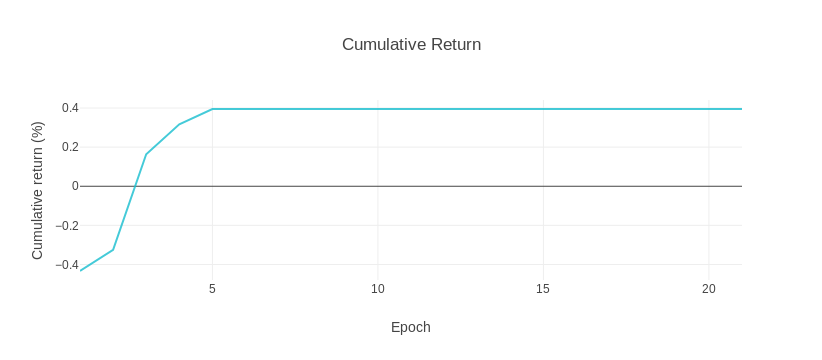

In [3]:
# Specify the start and end dates for this period.
start_d = dt.datetime(2008, 1, 1)
end_d = dt.datetime(2009, 12, 31)

# Get benchmark data
benchmark_prices = get_data([symbol], pd.date_range(start_d, end_d), addSPY=False).dropna()

# Create benchmark data: Benchmark is a portfolio starting with $100,000, investing in 1000 shares of symbol and holding that position
df_benchmark_trades = create_df_benchmark(symbol, start_d, end_d, num_shares)

#print (df_benchmark_trades)

# Train and test a StrategyLearner
# Set verbose to True will print out and plot the cumulative return for each training epoch
stl = strategyLearner(num_shares=num_shares, impact=impact, 
                      commission=commission, verbose=True,
                      num_states=3000, num_actions=3)
stl.add_evidence(symbol=symbol, start_val=start_val, 
                 start_date=start_d, end_date=end_d)
df_trades = stl.test_policy(symbol=symbol, start_date=start_d,
                            end_date=end_d)
#print (df_trades)



### Training market simulator


Performances during training period for JPM
Date Range: 2008-01-01 00:00:00 to 2009-12-31 00:00:00
Sharpe Ratio of Portfolio: 1.3048308973954665
Sharpe Ratio of Benchmark : 0.15691840642403027

Cumulative Return of Portfolio: 0.3951
Cumulative Return of Benchmark : 0.012299999999999978

Standard Deviation of Portfolio: 0.008676449618567592
Standard Deviation of Benchmark : 0.017004366271213767

Average Daily Return of Portfolio: 0.0007131748358620718
Average Daily Return of Benchmark : 0.00016808697819094035

Final Portfolio Value: 139510.0
Final Benchmark Value: 101230.0

Portfolio Orders count: 494


/home/emi/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:396: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




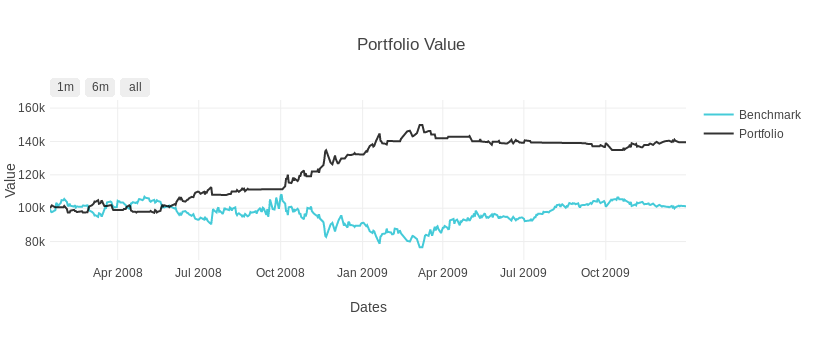

In [4]:
# Retrieve performance stats via a market simulator
print ("Performances during training period for {}".format(symbol))
print ("Date Range: {} to {}".format(start_d, end_d))
orders_count, sharpe_ratio, cum_ret, std_daily_ret, avg_daily_ret, final_value = market_simulator(df_trades, df_benchmark_trades, symbol=symbol, 
                 start_val=start_val, commission=commission, impact=impact, title="Portfolio Value", xtitle="Dates", ytitle="Value")

## Out of sample performance

Show the performances of portfolio and benchmark in the out of sample period. Use the same StrategyLearner trained above and retrieve a trades dataframe via test_policy.

In [5]:
# Specify the start and end dates for this period.
start_d = dt.datetime(2010, 1, 1)
end_d = dt.datetime(2011, 12, 31)

# Get benchmark data
benchmark_prices = get_data([symbol], pd.date_range(start_d, end_d), addSPY=False).dropna()

# Create benchmark data: Benchmark is a portfolio starting with $100,000, investing in 1000 shares of symbol and holding that position
df_benchmark_trades = create_df_benchmark(symbol, start_d, end_d, num_shares)

#print (df_benchmark_trades)

# Test a StrategyLearner
# Use the same StrategyLearner trained above and retrieve a trades dataframe via test_policy
df_trades = stl.test_policy(symbol=symbol, start_date=start_d,
                            end_date=end_d)
#print (df_trades)



/home/emi/Jupyter/ML4T_2018Spring/strategy_learner/indicators.py:100: FutureWarning:

pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).apply(func=<function>,args=<tuple>,kwargs=<dict>)



### Test market simulator


Performances during test period for JPM
Date Range: 2010-01-01 00:00:00 to 2011-12-31 00:00:00
Sharpe Ratio of Portfolio: -0.3294027274113046
Sharpe Ratio of Benchmark : -0.2568129607376273

Cumulative Return of Portfolio: -0.07550000000000001
Cumulative Return of Benchmark : -0.08340000000000003

Standard Deviation of Portfolio: 0.006619484810427323
Standard Deviation of Benchmark : 0.008481007498803986

Average Daily Return of Portfolio: -0.00013735709912805375
Average Daily Return of Benchmark : -0.00013720316019481813

Final Portfolio Value: 92450.0
Final Benchmark Value: 91660.0

Portfolio Orders count: 494


/home/emi/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:396: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




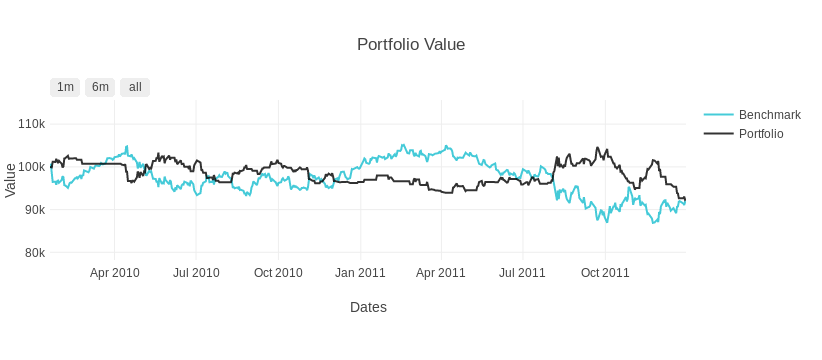

In [6]:
# Retrieve performance stats via a market simulator
print ("Performances during test period for {}".format(symbol))
print ("Date Range: {} to {}".format(start_d, end_d))
orders_count, sharpe_ratio, cum_ret, std_daily_ret, avg_daily_ret, final_value = market_simulator(df_trades, df_benchmark_trades, symbol=symbol, 
                 start_val=start_val, commission=commission, impact=impact, title="Portfolio Value", xtitle="Dates", ytitle="Value")

In [19]:
df_trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142 entries, 2010-01-19 to 2011-12-30
Data columns (total 1 columns):
Shares    142 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


# Report

Describe the steps you took to frame the trading problem as a learning problem for your learner. What are your indicators? Did you adjust the data in any way (dicretization, standardization)? Why or why not?

**Steps:**

1. Get adjusted close prices for symbol.
2. Set the QLearner parameters:
    * num_shares: The number of shares that can be traded in one order
    * epochs: The number of times to train the QLearner
    * num_steps: The number of steps used in getting thresholds for the
    discretization process. It is the number of groups to put data into.
3. Compute technical indicators and use them as features to be fed into a Q-learner.
    * Momentum
    * SMA indicator
    * RSI indicator
4. Get features and thresholds.
5. Define states, actions, and rewards. 
    * States are combinations of our features. 
    * Actions are buy, sell, do nothing. 
    * Rewards:
        Calculate the daily reward as a percentage change in prices: 
        - Position is long: if the price goes up (curr_price > prev_price),
          we get a positive reward; otherwise, we get a negative reward
        - Position is short: if the price goes down, we get a positive reward;
        otherwise, we a negative reward
        - Position is cash: we get no reward
6. Set initial position holding to nothing.
7. Create a series that captures order signals based on actions taken.
8. Iterate over the data by date.
    * Discretize features and return a state. Get a state; add 1 to position so that states >= 0.
    * On the first day, get an action without updating the Q-table.
    * On the last day, close any open positions.
    * Add new_pos to orders.
    * Update current position.
9. Create a trade dataframe.
10. Training: Choose the training period and you iterate over that training period and update your Q-table on each iteration. When you reach the end of that training period you backtest to see how good the model is and you go back and repeat, until the model quits getting better.
Once it's converged you stop, you've got your model.
11. Testing the model: You just backtest it on later data.

    

## Indicator charts

### Momentum chart

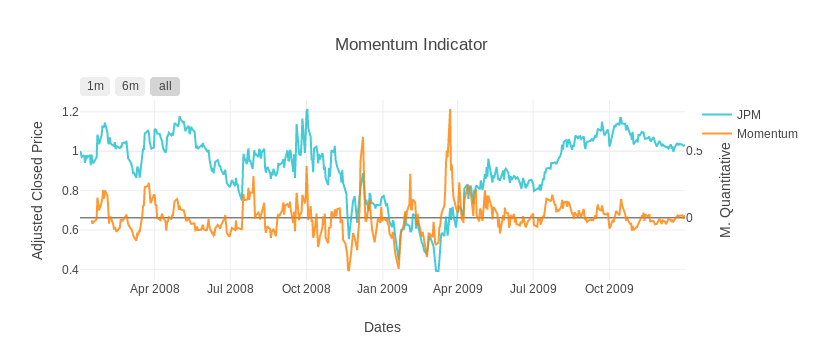

In [31]:
# Specify the start and end dates for this period.
start_d = dt.datetime(2008, 1, 1)
end_d = dt.datetime(2009, 12, 31)

# Set dates
dates = pd.date_range(start_d, end_d)

# Get adjusted close prices for symbol
df = get_data([symbol], dates, addSPY=False)
df = df_prices.dropna()


# Normalize the prices Dataframe
normed = pd.DataFrame()
for column in df:
    normed[column] = df[column].values / df[column].iloc[0];

# 2. Compute momentum
sym_mom = get_momentum(normed[column], window=10)

# 3. Plot raw JPM values and Momentum
plot_momentum(dates, df.index, normed[column], sym_mom, title="Momentum Indicator",
              fig_size=(12, 8))

### SMA indicator

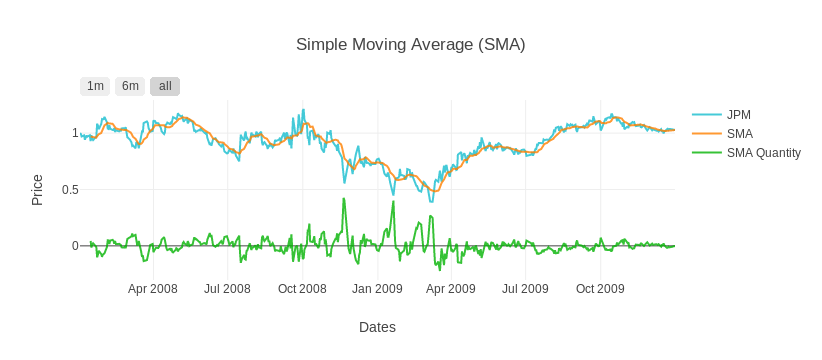

In [39]:
# Specify the start and end dates for this period.
start_d = dt.datetime(2008, 1, 1)
end_d = dt.datetime(2009, 12, 31)

# Set dates
dates = pd.date_range(start_d, end_d)

# Get adjusted close prices for symbol
df = get_data([symbol], dates, addSPY=False)
df = df_prices.dropna()

# Normalize the prices Dataframe
normed = pd.DataFrame()
for column in df:
    normed[column] = df[column].values / df[column].iloc[0];

# Compute SMA
sma_JPM, q = get_sma(normed[column], window=10)

# Plot symbol values, SMA and SMA quality
plot_sma_indicator(dates, df.index, normed[column], sma_JPM, q, "Simple Moving Average (SMA)")


### RSI indicator

In [ ]:
# Specify the start and end dates for this period.
start_d = dt.datetime(2008, 1, 1)
end_d = dt.datetime(2009, 12, 31)

# Set dates
dates = pd.date_range(start_d, end_d)

# Get adjusted close prices for symbol
df = get_data([symbol], dates, addSPY=False)
df = df_prices.dropna()

# 1. Compute RSI
rsi_JPM = get_RSI(df['JPM'])

# 2. Plot RSI
plot_rsi_indicator(dates, df.index, df['JPM'], rsi_JPM, window=14, 
                   title="RSI Indicator", fig_size=(12, 6))
